In [ ]:
!pip install rasterio

In [253]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF


class DoubleConvolution(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConvolution, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(
        self,
        input_channels=3,
        output_channels=1,
        features=[64, 128, 256, 512],
    ):
        super(UNet, self).__init__()

        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder
        for f in features:
            self.downs.append(DoubleConvolution(input_channels, f))
            input_channels = f

        # lower bottleneck layers
        self.bottleneck = DoubleConvolution(features[-1], features[-1] * 2)

        # Decoder
        for f in reversed(features):
            self.ups.append(
                nn.Sequential(
                    nn.Upsample(scale_factor=2),
                    nn.Conv2d(
                        in_channels=2 * f, out_channels=f, kernel_size=3, padding=1
                    ),
                )
            )
            self.ups.append(DoubleConvolution(2 * f, f))

        self.final_convolution = nn.Conv2d(
            in_channels=features[0],
            out_channels=output_channels,
            kernel_size=3,
            padding=1,
        )

    def forward(self, x):
        skip_connections = list()
        for module in self.downs:
            x = module(x)
            skip_connections.append(x)
            x = self.pool(x)

        skip_connections = skip_connections[::-1]  # reverse order

        x = self.bottleneck(x)

        for i in range(0, len(self.ups), 2):
            x = self.ups[i](x)
            skip_connection = skip_connections[i // 2]
            if skip_connection.shape != x.shape:
                x = TF.resize(
                    x,
                    size=skip_connection.shape[2:],
                    interpolation=TF.InterpolationMode.NEAREST,
                )
            x = torch.cat([skip_connection, x], dim=1)
            x = self.ups[i + 1](x)

        x = self.final_convolution(x)

        return x

In [254]:
import numpy as np
import torchvision.transforms.functional as F


class RandomVerticalFlip2Images():
    def __init__(self, p: float = 0.5):
        self.p = p

    def __call__(self, images):
        image, label = images
        if np.random.rand() < self.p:
            image = F.vflip(image)
            label = F.vflip(label)
        return image, label


class RandomHorizontalFlip2Images():
    def __init__(self, p: float = 0.5):
        self.p = p

    def __call__(self, images):
        image, label = images
        if np.random.rand() < self.p:
            image = F.hflip(image)
            label = F.hflip(label)
        return image, label


class RandomRotation2Images():
    def __init__(self, degrees: float = 90):
        self.degrees = degrees

    def __call__(self, images):
        image, label = images
        angle = np.random.uniform(-self.degrees, self.degrees)
        image = F.rotate(image, angle)
        label = F.rotate(label, angle)
        return image, label

In [255]:
from torch.utils.data import Dataset
import numpy as np
import os

import rasterio


class CloudDataset(Dataset):
    def __init__(self, images, labels, transform_image=None, transform_label=None, augment=None):
        self.images = images
        self.labels = labels
        self.transform_image = transform_image
        self.transform_label = transform_label
        self.augment = augment

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx: int):
        image = rasterio.open(self.images[idx]).read()
        label = rasterio.open(self.labels[idx]).read()

        image = image.astype(np.float32)
        label = label.astype(np.float32)

        image = np.moveaxis(image, 0, -1)
        label = np.moveaxis(label, 0, -1)

        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_label:
            label = self.transform_label(label)
        if self.augment:
            image, label = self.augment((image, label))

        return image, label

In [256]:
def train(model, loader, optimizer, criterion, device, batch_checkpoint_path, last_batch_checkpoint):
    model.train()
    train_loss = 0.0

    for batch_idx, (data, target) in enumerate(loader):
        if batch_idx <= last_batch_checkpoint:
            continue

        print(f"Train batch {batch_idx}/{len(loader)}")

        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        output = model(data)
        loss = criterion(output, target)

        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        if batch_idx % 500 == 0:
            torch.save(model.state_dict(), f"{batch_checkpoint_path}{batch_idx}.pt")

    return train_loss / len(loader)

In [257]:
def test(model, loader, criterion, device):
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(loader):
            print(f"Test batch {batch_idx}/{len(loader)}")

            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()

    return test_loss / len(loader)

In [258]:
def compute_dataset_info(train_images, train_labels, val_images, val_labels, test_images, test_labels):
    dataset_info = {
        "num_positives": 0,
        "num_negatives": 0,
        "mean": [0.0] * 13,
        "std": [0.0] * 13,
    }

    for images, labels in [
        (train_images, train_labels),
        (val_images, val_labels),
        (test_images, test_labels),
    ]:
        for image, label in zip(images, labels):
            try:
                label = rasterio.open(label).read()
                label = np.moveaxis(label, 0, -1)
                label = label.astype(np.float32)
                dataset_info["num_positives"] += np.sum(label)
                dataset_info["num_negatives"] += np.prod(label.shape) - np.sum(label)
            except Exception as e:
                print(e)
                print(label)

            try:
                image = rasterio.open(image).read()
                image = np.moveaxis(image, 0, -1)
                image = image.astype(np.float32)
                dataset_info["mean"] += np.mean(image, axis=(0, 1))
                dataset_info["std"] += np.std(image, axis=(0, 1))
            except Exception as e:
                print(e)
                print(image)


    dataset_info["mean"] /= (
        len(train_images) + len(test_images)
    )
    dataset_info["std"] /= (
        len(train_images) + len(test_images)
    )

    return dataset_info

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

In [259]:
from torch.utils.data import DataLoader
from torchvision import transforms

SEED = 42
BATCH_SIZE = 4
NUM_EPOCHS = 2
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
NUM_WORKERS = 0 if os.name == "nt" else 2
DATA_DIR = os.path.join("drive", "MyDrive", "data")
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")
DATASET_INFO_PATH = os.path.join(DATA_DIR, "dataset_info.pt")
CHECKPOINTS_DIR = "checkpoints"

os.makedirs(CHECKPOINTS_DIR, exist_ok=True)

torch.manual_seed(SEED)
np.random.seed(SEED)

train_and_val_images = []
for path in os.listdir(TRAIN_DIR):
    for img in os.listdir(os.path.join(TRAIN_DIR, path, "image")):
        if not ".ipynb_checkpoints" in img:
            train_and_val_images.append(os.path.join(TRAIN_DIR, path, "image", img))

val_percentage = 0.2
train_images = train_and_val_images[: int(len(train_and_val_images) * (1 - val_percentage))]
val_images = train_and_val_images[int(len(train_and_val_images) * (1 - val_percentage)) :]
train_labels = [path.replace("image", "label") for path in train_images]
val_labels = [path.replace("image", "label") for path in val_images]

test_images = []
for path in os.listdir(TEST_DIR):
    for img in os.listdir(os.path.join(TEST_DIR, path, "image")):
        if not ".ipynb_checkpoints" in img:
            test_images.append(os.path.join(TEST_DIR, path, "image", img))

test_labels = [path.replace("image", "label") for path in test_images]

if not os.path.exists(DATASET_INFO_PATH):
    dataset_info = compute_dataset_info(train_images, train_labels, val_images, val_labels, test_images, test_labels)
    torch.save(dataset_info, DATASET_INFO_PATH)

dataset_info = torch.load(DATASET_INFO_PATH)

transform_image = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(dataset_info["mean"], dataset_info["std"]),
])
transform_label = transforms.Compose([
    transforms.ToTensor(),
])
augment = transforms.Compose([
    RandomHorizontalFlip2Images(0.5),
    RandomVerticalFlip2Images(0.5),
    RandomRotation2Images(90),
])

train_dataset = CloudDataset(train_images, train_labels, transform_image, transform_label, augment)
val_dataset = CloudDataset(val_images, val_labels, transform_image, transform_label)
test_dataset = CloudDataset(test_images, test_labels, transform_image, transform_label)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

model = UNet(input_channels=13, output_channels=1).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss(
    pos_weight=torch.tensor(dataset_info["num_negatives"] / dataset_info["num_positives"]).to(DEVICE)
)

print("Number of cloud pixels:", dataset_info["num_positives"])
print("Number of non-cloud pixels:", dataset_info["num_negatives"])

Number of cloud pixels: 0.0
Number of non-cloud pixels: 186050.0


C:\Users\Danny\AppData\Local\Temp\ipykernel_21856\1232873820.py:73: RuntimeWarning: divide by zero encountered in scalar divide
  pos_weight=torch.tensor(dataset_info["num_negatives"] / dataset_info["num_positives"]).to(DEVICE)


In [260]:
train_losses = []
val_losses = []

for epoch in range(NUM_EPOCHS):
    os.makedirs(os.path.join("checkpoints", f"epoch_{epoch}"), exist_ok=True)
    checkpoint_path = os.path.join("checkpoints", f"epoch_{epoch}", f"unet.pt")

    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        train_losses.append(checkpoint["train_loss"])
        val_losses.append(checkpoint["val_loss"])
    else:
        batch_checkpoint_path = os.path.join("checkpoints", f"epoch_{epoch}", f"unet_batch_")
        last_checkpoint_batch = -1

        for filename in os.listdir("checkpoints"):
            if filename.startswith("unet_batch_"):
                last_checkpoint_batch = max(last_checkpoint_batch, int(filename.split("_")[-1]))

        if last_checkpoint_batch != -1:
            checkpoint = torch.load(batch_checkpoint_path + str(last_checkpoint_batch) + ".pt", map_location=DEVICE)
            model.load_state_dict(checkpoint["model_state_dict"])
            optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

        train_loss = train(model, train_loader, optimizer, criterion, DEVICE, batch_checkpoint_path, last_checkpoint_batch)
        val_loss = test(model, test_loader, criterion, DEVICE)

        checkpoint = {
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "train_loss": train_loss,
            "val_loss": val_loss,
        }
        torch.save(checkpoint, checkpoint_path)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

    print(f"Epoch: {epoch}, Train loss: {train_losses[-1]:.4f}, Test loss: {val_losses[-1]:.4f}")

Train batch 0/1


Saved batch checkpoint to checkpoints\epoch_0\unet_batch_
Test batch 0/1
Epoch: 0, Train loss: nan, Test loss: nan
Train batch 0/1
Saved batch checkpoint to checkpoints\epoch_1\unet_batch_
Test batch 0/1
Epoch: 1, Train loss: nan, Test loss: nan


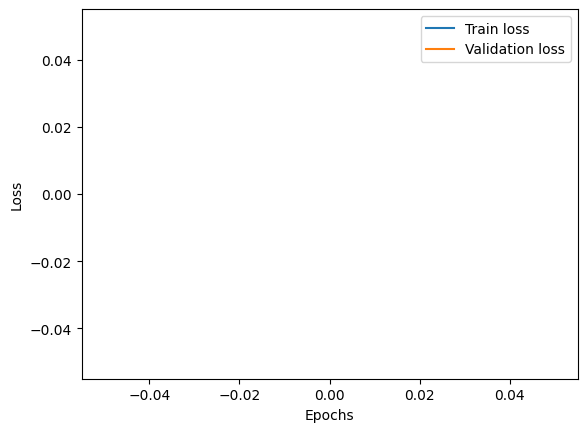

In [261]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Validation loss")
plt.legend(loc="best")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [262]:
THRESHOLD = 0.5

def show_batch(model, loader, device):
    batch = next(iter(loader))
    data, target = batch
    data, target = data.to(device), target.to(device)

    model.eval()
    with torch.no_grad():
        output = model(data)
        output = torch.sigmoid(output)
        thresholded_output = (output > THRESHOLD).float()

    output = output.cpu().numpy()
    thresholded_output = thresholded_output.cpu().numpy()
    target = target.cpu().numpy()
    data = data.cpu().numpy()

    for i in range(len(output)):
        _, ax = plt.subplots(1, 4, figsize=(15, 5))
        ax[0].imshow(data[i, 3, :, :], cmap="gray")
        ax[1].imshow(target[i, 0, :, :], vmin=0, vmax=1, cmap="gray")
        ax[2].imshow(output[i, 0, :, :], vmin=0, vmax=1, cmap="gray")
        ax[3].imshow(thresholded_output[i, 0, :, :], vmin=0, vmax=1, cmap="gray")
        plt.show()

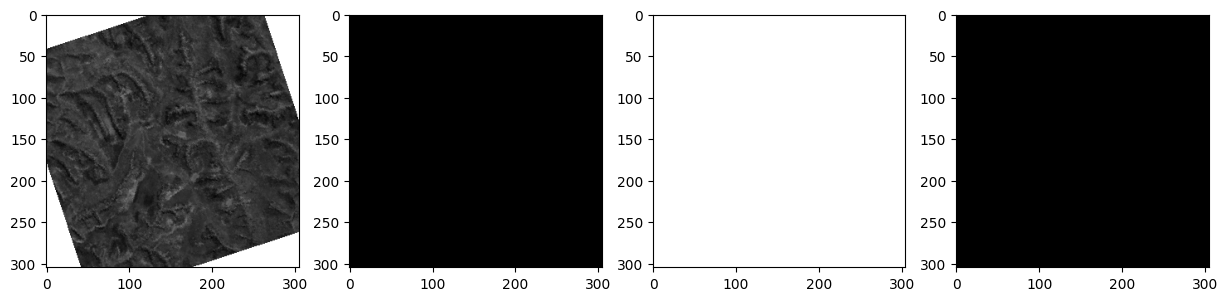

In [263]:
show_batch(model, train_loader, DEVICE)

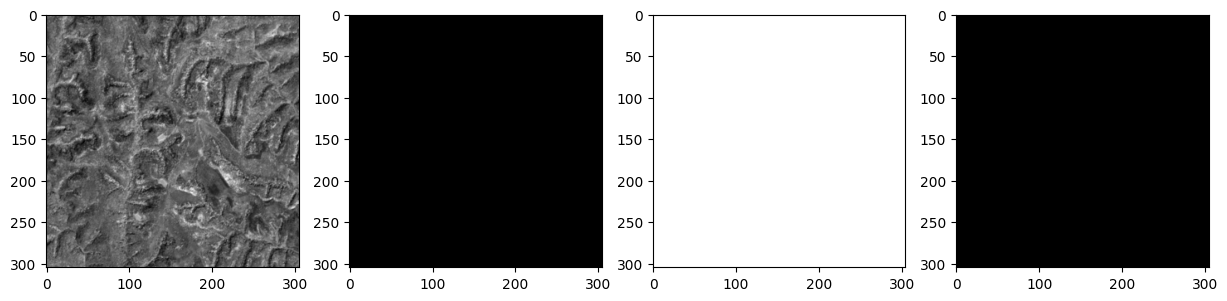

In [264]:
show_batch(model, val_loader, DEVICE)

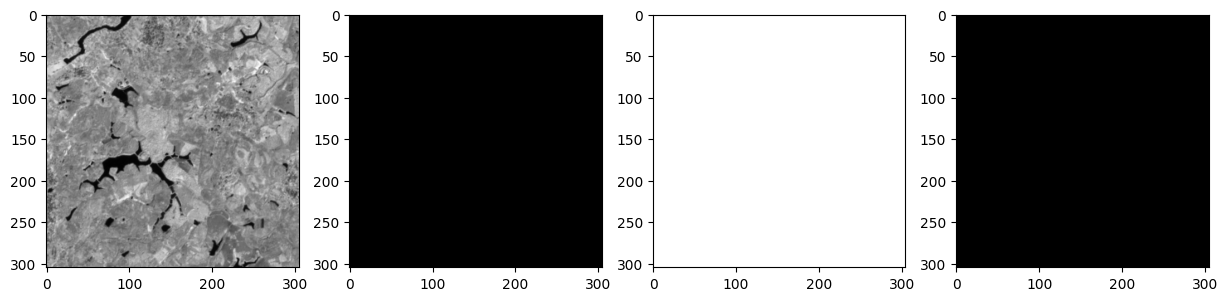

In [265]:
show_batch(model, test_loader, DEVICE)